# <u>TP1</u>

## par Antoine Boissinot  - -  François Gaudreault  - -  Béatrice Lessard-Hamel

## Présenté à M. Philippe Després

### Date de remise : 19 février 2021


In [1]:
### Modules et constantes ###
import timeit
import numpy as np
import scipy 
import scipy.constants as cst
from numpy import sqrt, pi, log, linspace, loadtxt
from math import exp
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import moyal
import matplotlib.pyplot as plt 

np.seterr(divide = 'ignore')

# Constantes des protons et électrons

# rayon classique d'un électron [cm]
r_e = cst.physical_constants["classical electron radius"][0]*100

# énergie de masse d'un électron/c^2 [MeV/c^2]
m_e_c2 = cst.physical_constants["electron mass energy equivalent in MeV"][0]


# énergie de masse d'un proton/c^2 [MeV/c^2]
m_p_c2 = cst.physical_constants["proton mass energy equivalent in MeV"][0]

## Numéro 1  

La densité électronique, $n_e$, d'un milieu peut être calculée, selon la formule suivante: $$n_e=\frac{N_{A}\cdot Z \cdot \rho}{M},$$ où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $M$ est la masse molaire du milieu ($M = A \cdot M_u$), $A$ est la masse atomique relative et $M_{u}$ la constante de masse molaire ($M_{u} = 1 g/cm^3$). 

Les propriétés des [milieux](https://www.physics.nist.gov/cgi-bin/Star/compos.pl?ap) et des [éléments](https://www.ptable.com) les composants sont obtenues à l'aide du site du NSIT et du site Ptable respectivement.

In [3]:
# Propriétés des milieux (eau liquide et os compacte) sous forme de dictionnaire 

                        
eau_liq = {"Densité" : 1.00000E+00,
           "MEE" : 75.000000E-06,
           "Composition" : np.array([[1, 8], 
                                     [0.111894, 0.888106], 
                                     [1.008, 15.999]])} 


os_compact = {"Densité" : 1.85000E+00, 
              "MEE" : 91.900000E-06,
              "Composition" : np.array([[1, 6, 7, 8, 12, 15, 16, 20], 
                                        [0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000],
                                        [1.008, 12.011, 14.007, 15.999, 24.305, 30.738, 32.065, 40.078]])} 
    # Densité [g/cm^3]
    # Énergie moyenne d'excitation [MeV]
        #Numéro atomique
        #Proportion dans le milieu
        #masse molaire [g/mol]

In [4]:
# fonction de la densité électronique selon les propriétés du milieu [électrons/cm^3]

def n_e(num_ato, proportion, mass_mol, densité):
    return cst.Avogadro * densité * np.sum(proportion * num_ato / mass_mol) 

In [6]:
# n_e pour l'eau liquide et un os compact

eau_liq["n_e"] = n_e(num_ato = eau_liq["Composition"][0], proportion = eau_liq["Composition"][1], 
                     mass_mol = eau_liq["Composition"][2], densité = eau_liq["Densité"])

os_compact["n_e"] = n_e(num_ato = os_compact["Composition"][0], proportion = os_compact["Composition"][1], 
                        mass_mol = os_compact["Composition"][2], densité = os_compact["Densité"])

print("Valeur de la densité électronique \n   Eau liquide : {:.2E} [électrons/cm^3]\n   Os compact : {:.2E} [électrons/cm^3]".format(eau_liq["n_e"], os_compact["n_e"]))

Valeur de la densité électronique 
   Eau liquide : 3.34E+23 [électrons/cm^3]
   Os compact : 5.91E+23 [électrons/cm^3]


Comme l'application de la protonthérapie produit des faisceaux de particules dans la gamme de 70 à 250 MeV, soit des protons de plus de 3 MeV, il est possible d'obtenir le pouvoir d'arrêt collisionnel selon l'énergie d'un proton comme suit : 

$$S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2}\left[\ln\left(\frac{2m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right],$$


où $r_e$ est le rayon d'un électron classique, $m_e$ est la masse d'un électron, $c$ est la vitesse de la lumière, $T_e^{max}$ est l'énergie maximale transférable à un électron par le proton, $I$ est l'énergie moyenne d'excitation du matériau et $\beta$ et $\gamma$ sont les facteurs de Lorentz.

In [7]:
# facteur de Lorentz selon l'énergie du proton

def gamma(T):
    return (T/(m_p_c2)) + 1

def beta(T):
    beta = sqrt((gamma(T)**2 - 1) / gamma(T)**2)
    return beta

# Décomposition de Te_max comme les équations (6) de la page 4 de l'énoncé

a = 2 * m_e_c2
b = 1 + (m_e_c2 / m_p_c2)**2
d = 2*(m_e_c2 / m_p_c2)


def Te_max(T):
    return a*(gamma(T)**2 - 1) / (b + d * gamma(T))

In [8]:
# fonction de l'arrêt collisionnel pour un proton de plus de 3 MeV
# Pour faciliter la lecture, l'équation Scol est décomposée en variable t1 et t2

def t1(T):
    return 2 * pi * r_e**2 *m_e_c2 / (beta(T)**2)
def t2(T):
    return 2 * m_e_c2 * beta(T)**2 * gamma(T)**2

# Scol varie selon le milieu (eau ou os), en n_e et I. Il varie aussi selon l'énergie T du proton

def Scol(n_e, T, I):
    return t1(T) * n_e * (log(t2(T)*Te_max(T) / I**2) - 2*beta(T)**2)


In [9]:
# valeurs théorique de l'eau NSIT

data_water_NSIT = np.loadtxt("Scol_water_NSIT.txt",float)
data_water_NSIT_x = data_water_NSIT[:,0]
data_water_NSIT_y = data_water_NSIT[:,1]

# valeurs théorique de l'os compact NSIT

data_bone_NSIT = np.loadtxt("Scol_bone_NSIT.txt",float)
data_bone_NSIT_x = data_bone_NSIT[:,0]
data_bone_NSIT_y = data_bone_NSIT[:,1]


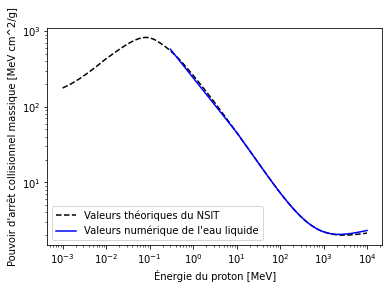

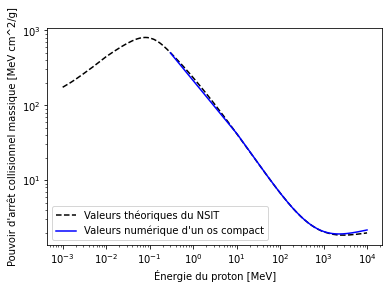

In [12]:
# Présentation des courbes

##### eau liquide #####
 

xpoints_w = linspace(0.3, 10000, 1000)
ypoints_w = []

#Les propriétés sont reprises dans les dictionnaires du premier bloc.
# les valeurs de la fonction Scol() sont divisées par la densité pour obtenir le pouvoir d'arrêt collisionnel massique
# et ainsi les comparer avec les valeurs de NSIT

for T in xpoints_w:
    ypoints_w.append(Scol(eau_liq["n_e"], T, eau_liq["MEE"])/ (eau_liq["Densité"]))

plt.plot(data_water_NSIT[:,0], data_water_NSIT[:,1], "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_w, ypoints_w,"b", label="Valeurs numérique de l'eau liquide")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel massique [MeV cm^2/g]")
plt.legend()
plt.show()


##### os compact ######


xpoints_b = linspace(0.3, 10000, 1000)
ypoints_b = []

for T in xpoints_b:
    ypoints_b.append(Scol(os_compact["n_e"], T, os_compact["MEE"]) / os_compact["Densité"])


plt.plot(data_bone_NSIT[:,0], data_bone_NSIT[:,1], "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_b, ypoints_b,"b", label="Valeurs numérique d'un os compact")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel massique [MeV cm^2/g]")
plt.legend()
plt.show()



# Numéro 2

L'homogénéité dimensionnelle peut être vérifiée lorsque deux grandeurs s'expriment dans la même unité. On souhaite vérifier l'homogénéité de $R_{CSDA}$ qui est définie par l'équation suivante: $$R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}}.$$ Sachant que $R_{C S D A}$ représente la portée des protons dans un milieu, elle doit donc être exprimée en unité longueur. On souhaite donc que le côté gauche de l'équation soit réductible à une unité de longueur. L'énergie $T$ est exprimée en $[M L^2 T^{-2}]$, $S_{col}$, en $[M L T^{-2}]$ et finalement, $\rho$, en $[M L^{-3}]$. En remplaçant dans l'équation, on obtient: $$\frac{[M L^2 T^{-2}][M L^{-3}]}{[M L T^{-2}]} = \left[\frac{M}{L^2}\right].$$ Le côté droit de l'équation de départ n'est pas exprimé dans la même unité que le côté gauche, cela réfute l'homogénéité dimensionnelle de $R_{CSDA}$. Pour régler le problème d'homogénéité il suffit de diviser le côté droit par $\rho$. Lorsqu'on applique ce changement on obtient: $$ R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{S_{c o l}}.$$ La dimension est $[L]$ de chaque côté de l'équation lorsque le changement est appliqué.


# Numéro 3
Le pouvoir d’arrêt total est bien approximé par le pouvoir d’arrêt collisionnel massique aux énergies de la protonthérapie. En effet, lorsqu'on compare les valeurs du pouvoir d'arrêt total du NSIT avec le pouvoir d'arrêt collisionnel massique de 70 à 250 MeV sur le graphique de la question 1 on voit rapidement que les deux courbes sont très près l'une de l'autre. De façon un peu plus quantitative, il est possible d'utiliser l'erreur quadratique moyenne pour comparer les deux courbes:

In [15]:
#Valeurs de 70-250 MeV des courbes théoriques 
T = np.array(data_water_NSIT_x[71:105])

#Valeurs du pouvoir collisionnel massique de l'eau du NSIT de 70-250 MeV
Scol_eau_NSIT = np.array(data_water_NSIT_y[71:105])

#Valeurs du pouvoir collisionnel massique de l'eau calculée  de 70-250 MeV
Scol_eau_calculee = Scol(eau_liq["n_e"], T, eau_liq["MEE"]) / eau_liq["Densité"]

#Valeurs du pouvoir collisionnel massique de l'os du NSIT de 70-250 MeV
Scol_os_NSIT = np.array(data_bone_NSIT_y[71:105])

#Valeurs du pouvoir collisionnel massique de l'os calculée de 70-250 MeV
Scol_os_calculee = Scol(os_compact["n_e"], T, os_compact["MEE"]) / os_compact["Densité"]

# Root mean square error 
def rmse(y_1,y_2):
    return np.sqrt(((y_1 - y_2) ** 2).mean())

rmse_val_eau = rmse(Scol_eau_calculee, Scol_eau_NSIT)
rmse_val_os = rmse(Scol_os_calculee, Scol_os_NSIT)

print("L\'erreur quadratique moyenne pour l\'eau est: " + str(rmse_val_eau))
print("L\'erreur quadratique moyenne pour l\'os est: " + str(rmse_val_os))

L'erreur quadratique moyenne pour l'eau est: 0.1896355496194343
L'erreur quadratique moyenne pour l'os est: 0.23719012542237863


Comme on peut le constater, l'erreur quadratique moyenne est plutôt faible pour des valeurs allant de 70 à 250 MeV. Il est à noter que les valeurs théoriques du NSIT prennent en compte les pouvoirs d'arrêt électronique et nucléaire alors que le pouvoir d'arrêt calculé ne comprend que le pouvoir d'arrêt électronique. On comprend donc que le pouvoir d'arrêt nucléaire n'a pas énormément d'impact sur le résultat dans cette plage de valeur. En effet, le pouvoir d'arrêt nucléaire est souvent négligeable sauf pour des ions de très faible énergie comme on peut le voir sur le graphique suivant (l'eau a été choisie, car l'effet était plus important que pour l'os):   

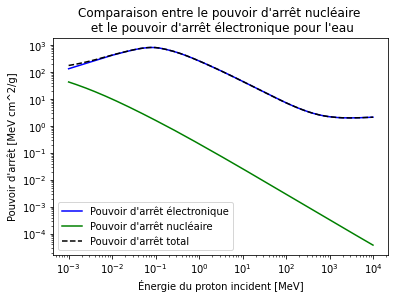

In [16]:
fichier = "All_water_data_NSIT.txt"
data = np.loadtxt(fichier, skiprows = 8)


plt.plot(data[:,0], data[:,1], "b", label="Pouvoir d'arrêt électronique")
plt.plot(data[:,0], data[:,2],"g", label="Pouvoir d'arrêt nucléaire")
plt.plot(data[:,0], data[:,3],"k--", label="Pouvoir d'arrêt total")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton incident [MeV]")
plt.ylabel("Pouvoir d'arrêt [MeV cm^2/g]")
plt.legend()
plt.title("Comparaison entre le pouvoir d'arrêt nucléaire \n et le pouvoir d'arrêt électronique pour l'eau")
plt.show()

L'autre pouvoir d'arrêt qui a été négligé est le pouvoir d'arrêt radiatif qui apparait lorsque le rayonnement de freinage du proton doit être considéré. Pour qu'il soit considéré, le proton doit avoir une énergie bien plus élevée que dans le cadre de la protonthérapie.


# Numéro 4
Une raison qui justifie l'emploi de méthodes numérique pour intégrer est la complexité importante de la fonction à intégrer soit: $1/S_{col}(T)$ En effet, afin de simplifier la fonction $S_col$, comme présentée au numéro 1, on peut paramétrer celle-ci avec $\gamma$, on obtient alors la fonction suivante (en utilisant la même notation que sur l'énoncé pour les constantes): $$ S_{col}(\gamma(T)) = U \left[ \frac{\gamma^2}{(\gamma^2 -1)} ln\left(\frac{ka \cdot (\gamma^2-1)^2}{b+\delta \gamma} \right) -2 \right]$$
Sous cette forme, en effectuant un petit changement de variable et modifiant les bornes d'intégration, sachant: $$\gamma(T) =\frac{T}{m_{p} c^{2}}+1,$$ il est possible d'intégrer l'inverse de cette fonction par rapport à gamma. Toutefois, en inspectant rapidement l'équation on s'aperçoit rapidement que celle-ci semble extrêmement ardue à évaluer à la main. 

Néanmoins, il est possible d'utiliser un algorithme ayant pour but de vérifier si la solution de l'intégrale est formée de fonctions élémentaires ce qui nous permettrait d'avoir une fonction analytique et il ne nous resterait plus qu'à évaluer la valeur de cette fonction aux bornes. Un exemple de ce genre d'algorithme est l'algorithme de Risch. Toutefois, celui-ci ne donne aucune une solution. 

Finalement, une dernière approche analytique pourrait être d'utiliser les premiers termes de la série de Maclaurin et d'intégrer ces termes. Cependant, les dérivées de cette fonction, bien que calculables (comme nous allons le voir pour la dérivée première au numéro 5), elles sont assez complexes. Il est donc plus simple d'évaluer l'intégrale numériquement.  



# Numéro 5
Intégration par la méthode des trapèzes et par Simpson

In [17]:
def trapeze(func,a,b,N):
    #--Calcul d'intégration par méthode des trapèzes

    #--Paramètres:
    #   func: Fonction à intégrer
    #   a,b: Borne inférieure(a) et supérieure(b) de l'intégrale
    #   N: Nombre de tranches

    #--Retourne la solution à l'intégration

    h = abs(b - a) / N  # Largeur des tranches
    x= np.linspace(a,b,N+1) #N+1 points dans l'intervale [a,b]
    y=func(x)
    return h*(0.5*y[0]+0.5*y[-1]+np.sum(y[1:-1])) #Aire de l'ensemble des segments

def simpson(func,a,b,N):
    #--Calcul d'intégration par méthode de Simpson

    #--Paramètres:
    #   func: Fonction à intégrer
    #   a,b: Borne inférieure(a) et supérieure(b) de l'intégrale
    #   N: Nombre de tranches

    #--Retourne la solution à l'intégration
    
    h = abs(b - a) / N  # Largeur des tranches
    x= np.linspace(a,b,N+1) #N+1 points dans l'intervale [a,b]
    y=func(x)
    yimp = y[1:-1:2] #Somme sur les impairs
    s1 = np.sum(yimp)
    ypair = y[2:-2:2] #Somme sur les pairs
    s2 = np.sum(ypair)
    return h/3*(y[0] + y[-1] + s1*4+s2*2) #Aire de l'ensemble des segments

Algorithme d'intégration pour calculer la portée des protons

In [18]:
def error(func,a,b,N0,precision,type):
    #--Intégration à l'aide de la méthode de Simpson ou de trapèzes avec un nombre de
    #tranches maximal permettant de se rapprocher d'une certaine précision

    #--Paramètres:
    #   func: Fonction à intégrer
    #   a,b: Borne inférieure(a) et supérieure(b)
    #   N0: Nombre initial de tranches 
    #   precision: Précision recherchée
    #   type: 'Simpson' ou 'Trapèzes'
    #
    #--Retourne la solution à l'intégrale selon la méthode avec un nombre de tranches 
    #maximal permis par la précision recherchée.
    #   iN: Valeur de l'intégrale calculée à Nmax tranches.
    #   Nombre de tranches maximales pour atteindre la précision recherchée.
    #   err[-1] Valeur de l'erreur sur le calcul de l'intégrale
    #
    #Initialisation des listes de solutions et d'erreurs d'intérale
    s = []
    err = []
    #Première itération
    i0 = trapeze(func,a,b,N0)
    s.append(i0)
    
    #Deuxième itération avec 2*N0
    N = 2 * N0
    if type == 'Trapèzes':
        iN = trapeze(func,a,b,N)
        s.append(iN)
        err.append(abs(iN-i0)/3) #Erreur d'approximation sur l'évaluation avec 2N tranches Trapèzes
        
        #Itérations pour trouvées Nmax qui est atteint lorsque l'erreur est supérieure à la précision recherchée en doublant
        #le nombre de tranches.
        while err[-1] >= precision: #Cherche l'erreur se raprochant de la précision désirée
            i = iN
            N = 2 * N
            iN = trapeze(func,a,b,N)
            s.append(iN)
            err.append(abs((iN - i) / 3)) #Calcul d'erreur pour la méthode de trapèzes
    if type == 'Simpson':
        iN = simpson(func,a,b,N)
        s.append(iN)
        err.append(abs(iN-i0)/15) #Erreur d'approximation sur l'évaluation avec 2N tranches Simpson
        
        #Itérations pour trouvées Nmax qui est atteint lorsque l'erreur est supérieur à la précision recherchée en doublant 
        #le nombre de tranches.
        while err[-1] >= precision:
            i = iN
            N = 2 * N
            iN = simpson(func,a,b,N)
            s.append(iN)
            err.append(abs((iN - i) / 15)) #Calcul d'erreur pour la méthode de Simpson
    return iN,N,err
    if type != 'Simpson' and type!='Trapèzes':
        print("Méthode d'intégration invalide. Type = 'Simpson' ou 'Trapèzes'")

def Rcsda(Tp, n_e, I, rho,type):
    #Calcul de la portée de proton par CSDA à laide d'une méthode d'intégration.

    #Paramètres:
    #   Tp: Énergie du proton
    #   n_e: Densité électronique
    #   I: Énergie moyenne d'excitation
    #   rho: Masse volumique
    #   type: 'Simpson' ou 'Trapèzes'

    #Retourne la portée des proton dans le matériaux
    func = lambda T:1/ Scol(n_e,T, I) #Fonction à intégrée par rapport à l'énergie
    portee = 0
    if type == 'Trapèzes':
        portee = error(func, a=0.1, b=Tp, N0=1,precision=1e-13,type=type)
    if type == 'Simpson':
        portee = error(func, a=0.1, b=Tp, N0=1,precision=1e-13,type=type)
    if type != 'Simpson' and type!='Trapèzes':
        print("Méthode d'intégration invalide. Type = 'Simpson' ou 'Trapèzes'")
    return portee

Calcul de la portée des protons dans l'eau et dans l'os compact à l'aide de la méthode par trapèze et avec la méthode de Simpson. 

In [19]:
#Portée dans l'eau avec la méthode d'intégration par trapèzes
portee_eau_t, Nmax_eau_t, err_eau_t = Rcsda(150, eau_liq["n_e"],eau_liq["MEE"], eau_liq["Densité"],'Trapèzes')
print("On obtient une portée de {:.14f} cm dans l'eau avec l'algorithme d'intégrale par la \n méthode des trapèzes avec une précision de {:.2} cm pour un maximum de {} tranches.".format(portee_eau_t, err_eau_t[-1], Nmax_eau_t ))
print(" ")
#Portée dans l'eau avec la méthode d'intégration par Simpson
portee_eau_s, Nmax_eau_s, err_eau_s = Rcsda(150, eau_liq["n_e"],eau_liq["MEE"], eau_liq["Densité"],'Simpson')
print("On obtient une portée de {:.14f} cm dans l'eau avec l'algorithme d'intégrale par la \n méthode de Simpson avec une précision de {:.2} cm pour un maximum de {} tranches.".format(portee_eau_s, err_eau_s[-1], Nmax_eau_s ))
print(" ")
#Portée dans l'os compact avec la méthode par trapèzes
portee_os_t, Nmax_os_t, err_os_t = Rcsda(150, os_compact["n_e"],os_compact["MEE"], os_compact["Densité"],'Trapèzes')
print("On obtient une portée de {:.14f} cm dans l'os compact avec l'algorithme d'intégrale par \n la méthode des trapèzes avec une précision de {:.2} cm pour un maximum de {} tranches.".format(portee_os_t, err_os_t[-1], Nmax_os_t ))
print(" ")
#Portée dans l'os compact avec la méthode par Simpson
portee_os_s, Nmax_os_s, err_os_s = Rcsda(150, os_compact["n_e"],os_compact["MEE"], os_compact["Densité"],'Simpson')
print("On obtient une portée de {:.14f} cm dans l'os compact avec l'algorithme d'intégrale par \n la méthode des Simpson avec une précision de {:.2} cm pour un maximum de {} tranches.".format(portee_os_s, err_os_s[-1], Nmax_os_s ))


On obtient une portée de 15.76724773742493 cm dans l'eau avec l'algorithme d'intégrale par la 
 méthode des trapèzes avec une précision de 5.3e-14 cm pour un maximum de 2097152 tranches.
 
On obtient une portée de 15.76724773742492 cm dans l'eau avec l'algorithme d'intégrale par la 
 méthode de Simpson avec une précision de 4.5e-14 cm pour un maximum de 131072 tranches.
 
On obtient une portée de 9.16355961134560 cm dans l'os compact avec l'algorithme d'intégrale par 
 la méthode des trapèzes avec une précision de 4.4e-14 cm pour un maximum de 8388608 tranches.
 
On obtient une portée de 9.16355961134560 cm dans l'os compact avec l'algorithme d'intégrale par 
 la méthode des Simpson avec une précision de 6.4e-14 cm pour un maximum de 131072 tranches.


Maintenant que nous connaissons Nmax, on s'intéresse à la portée calculée en fonction du nombre de tranches pour chaque méthode. Nous avons choisi de faire une fonction permettant de calculer le nombre de tranches en doublant pour se rendre à ce Nmax qui permet de calculer la portée selon les deux méthodes. Notre fonction calcul aussi la différence logarithmique avec la valeur trouvée précédemment pour mettre en évidence le comportement des algorithmes. 

In [20]:

def npoint(Nmax):
    return log(Nmax)/log(2) #Nombres de points pour doubler le nombre de tranches jusqu'à Nmax

def dif(materiaux,type):
    #--Calcul de la portée Rcsda avec une intégration selon la méthode de Simpson ou des trapèzes
    #pour un matériau donné.
    #--Paramètres:
    #   matériaux: 'eau_liq' ou 'os_compact'
    #   type: 'Simpson' ou 'Trapèzes'
    #
    #--Retourne une liste du nombre de tranches, des valeurs calculées de Rcsda et de la
    #différence logarithmique avec la valeur calculée à Nmax.

    #Initialisation des listes
    Nmax = 0
    N =[]
    Rcsda = []
    differ = []
    
    #Nombres de points N et définition de la fonction selon le matériau et la méthode
    if materiaux == 'eau_liq':
        func = lambda T: 1 / Scol(eau_liq["n_e"], T, eau_liq["MEE"])
        if type == 'Trapèzes':
            Nmax = Nmax_eau_t
        if type == 'Simpson':
            Nmax =Nmax_eau_s
    if materiaux == 'os_compact':
        func = lambda T: 1/ Scol(os_compact["n_e"],T, os_compact["MEE"])
        if type == 'Trapèzes':
            Nmax = Nmax_os_t
        if type == 'Simpson':
            Nmax =Nmax_os_s
    #Calcul de Rcsda selon la méthode d'intégration
    if type == 'Trapèzes':
        k = npoint(Nmax)
        for i in range(int(k + 1)):
            N.append(2 ** i)
        for i in range(len(N)):
            s = trapeze(func, 0.1, 150, N[i])
            Rcsda.append(s)
    differ = [np.log10(abs(s- x)) for x in Rcsda] #différence logarithmique
    if type == 'Simpson':
        k = npoint(Nmax)
        for i in range(int(k + 1)):
            N.append(2 ** i)
        for i in range(len(N)):
            s = simpson(func, 0.1, 150, N[i])
            Rcsda.append(s)
    differ = [np.log10(abs(s- x)) for x in Rcsda] #différence logarithmique
    return N,Rcsda,differ

In [21]:
N_eau_t,Rcsda_eau_t,Dif_eau_t = dif('eau_liq','Trapèzes')
N_eau_s,Rcsda_eau_s,Dif_eau_s = dif('eau_liq','Simpson')
N_os_t,Rcsda_os_t,Dif_os_t = dif('os_compact','Trapèzes')
N_os_s,Rcsda_os_s,Dif_os_s = dif('os_compact','Simpson')

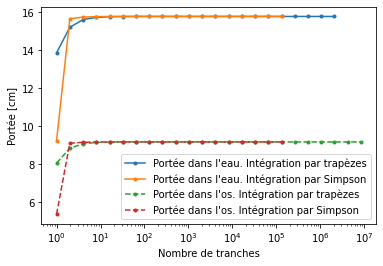

In [22]:
plt.plot(N_eau_t,Rcsda_eau_t,'-',marker='.',label="Portée dans l'eau. Intégration par trapèzes")
plt.plot(N_eau_s,Rcsda_eau_s,'-',marker='.',label="Portée dans l'eau. Intégration par Simpson")
plt.plot(N_os_t,Rcsda_os_t,'--',marker='.',label="Portée dans l'os. Intégration par trapèzes")
plt.plot(N_os_s,Rcsda_os_s,'--',marker='.',label="Portée dans l'os. Intégration par Simpson")

plt.ylabel("Portée [cm]")
plt.xlabel("Nombre de tranches")
plt.legend()
plt.xscale("log")
plt.show()

On voit que la méthode d'intégration par Simpson atteint plus rapidement la valeur attendue. Par contre, on remarque que c'est difficile d'observer le comportement de l'algorithme après plus de 100 tranches. En effet, les différences sont dans les décimales. C'est pourquoi nous avons choisi de représenter la différence logarithmique entre la valeur la plus précise et la valeur obtenue pour un nombre de tranches. La différence logarithmique permet d'observer la différence dans les décimales.

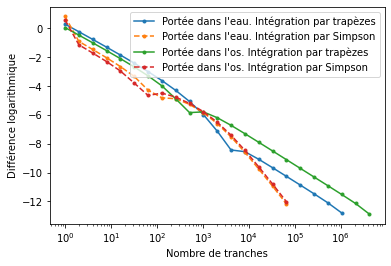

In [23]:
plt.plot(N_eau_t,Dif_eau_t,'-',marker='.',label="Portée dans l'eau. Intégration par trapèzes")
plt.plot(N_eau_s,Dif_eau_s,'--',marker='.',label="Portée dans l'eau. Intégration par Simpson")
plt.plot(N_os_t,Dif_os_t,'-',marker='.',label="Portée dans l'os. Intégration par trapèzes")
plt.plot(N_os_s,Dif_os_s,'--',marker='.',label="Portée dans l'os. Intégration par Simpson")

plt.legend()
plt.ylabel("Différence logarithmique")
plt.xlabel("Nombre de tranches")
plt.xscale("log")
plt.show()

On peut voir qu'il y a une 

# Numéro 6
L'objet de ce numéro est d'établir l’expression analytique du pouvoir d'arrêt en fonction de $T$. Pour ce faire, il serait particulièrement dommage de ne pas utiliser l'expression de $S_{col}(\gamma)$ utilisé au numéro 4. Pour s'en servir, il suffit d'utiliser la règle de dérivation en chaîne, dans ce cas: $$\frac{dS_{col}(T)}{dT} = \frac{dS_{col}(\gamma)}{d\gamma} \frac{d\gamma(T)}{dT}. $$ 
En utilisant Wolfram|Alpha on obtient l'équation suivante: 
$$ \frac{dS_{col}(\gamma)}{d\gamma} = -\dfrac{U{\gamma}\left(\left(2{\delta}{\gamma}+2b\right)\ln\left(\frac{ak\left({\gamma}^2-1\right)^2}{{\delta}{\gamma}+b}\right)-3{\delta}{\gamma}^3-4b{\gamma}^2-{\delta}{\gamma}\right)}{\left({\delta}{\gamma}+b\right)\left({\gamma}^2-1\right)^2}.$$ 
On obtient facilement: $$\frac{d\gamma(T)}{dT} = \frac{1}{m_pc^2}.$$
Donc, $$\frac{dS_{col}(T)}{dT} = -\frac{U}{m_pc^2}\left[ \dfrac{{\gamma}\left(\left(2{\delta}{\gamma}+2b\right)\ln\left(\frac{ak\left({\gamma}^2-1\right)^2}{{\delta}{\gamma}+b}\right)-3{\delta}{\gamma}^3-4b{\gamma}^2-{\delta}{\gamma}\right)}{\left({\delta}{\gamma}+b\right)\left({\gamma}^2-1\right)^2} \right].$$
On peut tracer cette fonction de la dérivée du pouvoir d'arrêt en fonction de l'énergie du proton incident: 


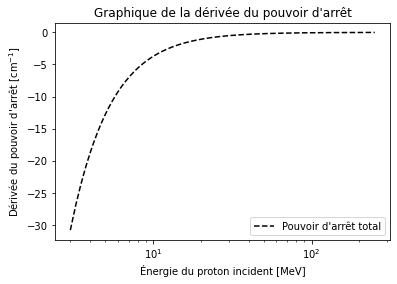

In [24]:
# Rappel des différents paramètres de la fonction 
a = 2 * m_e_c2
b = 1 + (m_e_c2 / m_p_c2)**2
d = 2*(m_e_c2 / m_p_c2)
U = 2 * pi * r_e**2 *m_e_c2 
T = np.linspace(3, 250, 1000)

def Scol_derivative(T, n_e, I): 
    return -U*n_e/m_p_c2*(((gamma(T)*(2*d*gamma(T)+2*b)*np.log((a*a/I**2*(gamma(T)**2-1)**2)/(d*gamma(T)+b)))- 3*d*gamma(T)**3 \
                           -4*b*gamma(T)**2 -d*gamma(T))/((d*gamma(T)+b)*(gamma(T)**2-1)**2))



plt.plot(T, Scol_derivative(T, eau_liq["n_e"], eau_liq["MEE"]),"k--", label="Pouvoir d'arrêt total")
plt.xscale("log")
plt.xlabel("Énergie du proton incident [MeV]")
plt.ylabel("Dérivée du pouvoir d'arrêt [cm$^{-1}$]")
plt.legend()
plt.title("Graphique de la dérivée du pouvoir d'arrêt")
plt.show() 

# Numéro 7

On reprend les données calculées d'erreurs d'approximations et d'intégrales pour chaque nombre de tranches calculées précédement.

In [25]:
data = {'Nombre de tranches': N_eau_s[1:], 'Portée calculée Trapèzes [cm]': Rcsda_eau_t[1:-4],
        "Portée calculée Simpson [cm]": Rcsda_eau_s[:-1], "Erreur d'approximation Trapèzes":err_eau_t[:-4],
        "Erreur d'approximation Simpson":err_eau_s}
pd.DataFrame(data)


,Nombre de tranches,Portée calculée Trapèzes [cm],Portée calculée Simpson [cm],Erreur d'approximation Trapèzes,Erreur d'approximation Simpson
0,2,15.197602,9.235192,4.482712e-01,1.195390e-01
1,4,15.599656,15.645873,1.340182e-01,5.853431e-03
2,8,15.718621,15.733674,3.965504e-02,1.640133e-03
3,16,15.753432,15.758276,1.160363e-02,4.506334e-04
4,32,15.763453,15.765036,3.340259e-03,1.171601e-04
5,64,15.766261,15.766793,9.358860e-04,2.688568e-05
6,128,15.767012,15.767197,2.505219e-04,4.413443e-06
7,256,15.767199,15.767263,6.212928e-05,1.336528e-07
8,512,15.767239,15.767261,1.359277e-05,5.172131e-07
9,1024,15.767247,15.767253,2.436991e-06,2.563205e-07


Le tableau ne permet pas d'afficher plus de 6 décimales. Par contre, on remarque ....

# Numéro 8
10 000 valeurs d'énergies du protons incidents ont été simulées avec la distribution moyal avec son maximum à 150 MeV :

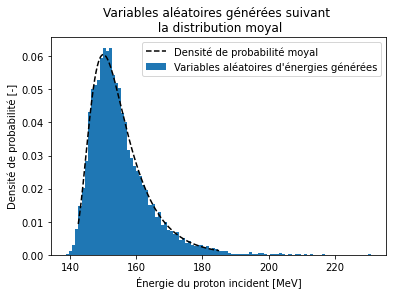

In [32]:
#Densité de probabilité moyal avec maximum à 150
moyal_150 = moyal(loc=150, scale=4)

#Énergie du proton incident
E = np.linspace(moyal_150.ppf(0.01), moyal_150.ppf(0.99), 10000)

#Densité de probabilité de l'énergie
p = moyal_150.pdf(E)

#10 000 valeurs d'énergie suivant la densité de probabilité moyal
T = moyal_150.rvs(size=10000)


plt.plot(E, p, "k--", label="Densité de probabilité moyal")
plt.hist(T, density=True, bins = 100, label="Variables aléatoires d'énergies générées")
plt.xlabel("Énergie du proton incident [MeV]")
plt.ylabel("Densité de probabilité [-]")
plt.legend()
plt.title("Variables aléatoires générées suivant \n la distribution moyal")
plt.show()


# Numéro 9

In [27]:
#Fonction à intégrer tout au long du numéro 
def to_integrate(T):
    return 1/(Scol(eau_liq["n_e"], T, eau_liq["MEE"]))

In [28]:
#Estimation du nombre de protons par seconde pouvant être évalués par Scipy.integrate.quad
#Intégration de la fonction pour 10 000 valeurs de protons, on commence à intégrer à partir de 3 MeV, car la fonction se 
#comporte mal avant

def integrate_scipy_quad(T):
    distances = np.zeros(10000)
    for i, value in enumerate(T):
         distances[i] = scipy.integrate.quad(to_integrate, a = 3, b = value, limit = 20, epsabs = 10**-9)[0]
    return distances

#Estimation du nombre de protons par seconde pouvant être évalués par la mèthode des trapèzes



#Estimation du nombre de protons par seconde pouvant être évalués par la mèthode de Simpson




#Mesure du temps d'exécution avec timeit
temps_scipy_quad = timeit.timeit('[integrate_scipy_quad(T)]', number = 1, globals=globals())
print("Il est possible d'évaluer environ {:.0f} portées de protons par seconde avec la méthode scipy.integrate.quad.".format(10000/temps_scipy_quad))

Il est possible d'évaluer environ 703 portées de protons par seconde avec la méthode scipy.integrate.quad.


Brièvement commenter les temps d'intégrations

In [29]:
distances = integrate_scipy_quad(T) 

# Numéro 10
L'histogramme des portées des différents protons à cet allure: 

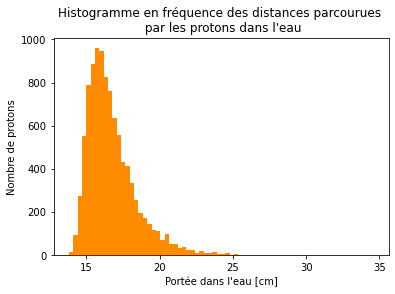

In [30]:
#Histogrammes des portées 
plt.hist(distances, bins = 70, color = "darkorange")
plt.title("Histogramme en fréquence des distances parcourues \n par les protons dans l'eau")
plt.ylabel("Nombre de protons")
plt.xlabel("Portée dans l'eau [cm]")
plt.show()

On voit que l'histogramme des distances des protons est très similaire à celui des énergies de protons générés suivant la distribution moyal. On peut encore mieux constater ce fait lorsqu'on trace une courbe de la distribution moyal centrée à environ 16 cm :

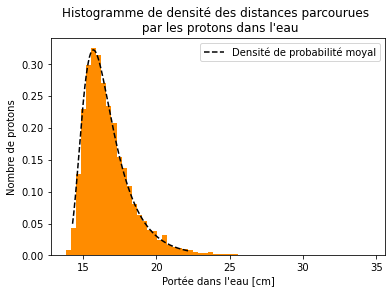

In [31]:
#Densité de probabilité moyal avec maximum à 16
moyal_16 = moyal(15.7, scale = 0.75)

#Valeurs en x de 0.01% à 99% de la distributions
x = np.linspace(moyal_16.ppf(0.01), moyal_16.ppf(0.99), 1000)


plt.plot(x, moyal_16.pdf(x), "k--", label="Densité de probabilité moyal")
plt.hist(distances, bins = 60, density = True, color = "darkorange")
plt.title("Histogramme de densité des distances parcourues \n par les protons dans l'eau")
plt.ylabel("Nombre de protons")
plt.xlabel("Portée dans l'eau [cm]")
plt.legend()
plt.show()

Cela n'a rien d'étonnant car, selon notre code, la trajectoire est entièrement déterminé selon l'énergie initiale du proton. Les énergies des protons suivent une densité de probabilité moyal, donc les trajectoires aussi. 

# Numéro 11

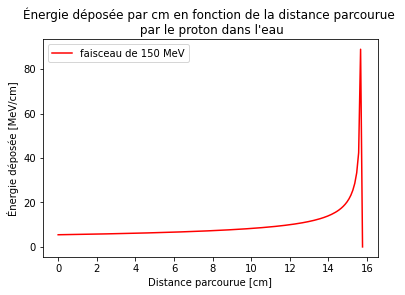

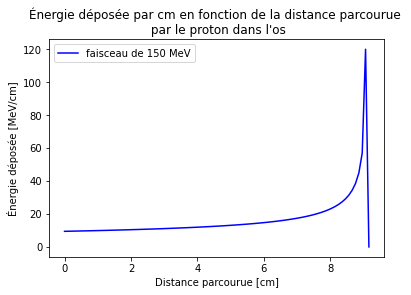

In [33]:
def proton_transport(T_i, T_f, n_e, I, N):
     #--Paramètres:
    #   T_i: Énergie initiale du proton [MeV]
    #   T_f: Énergie finale du proton [MeV]
    #   N: Nombre de division de l'énergie entre T_i et T_f
    #
    #--Retourne un vecteur de la profondeur parcourue [cm] ainsi qu'un vecteur de valeur d'énergie déposée par cm pour
    #  ces distances [MeV/cm]
    #--Le calcul est effectué suivant l'approximation d'une une décélération continue du proton incident. 
     
    
    T_step = np.linspace(T_f, T_i, N) #Sépration de l'énergie en pas constant
    s = np.zeros(len(T_step)-1) #Init vecteur distance parcourue à chaque pas d'énergie
    profondeur = np.zeros(len(T_step)) #Init vecteur de la pronfondeur parcourue
    func = lambda z: 1/Scol(n_e, z, I) #Fonction à intégrer 
    #Distance s parcourue à chacune des intégrales de T_step[i] à T_step[i+1]
    for i in range(len(T_step) - 1):
        s[i] =  simpson(func, a = T_step[i], b = T_step[i+1], N = 30000)
    
    #Profondeur en fonction du total des distances s parcourues 
    for i in range(len(T_step) - 1):
        profondeur[i+1] = np.sum(s[:(i+1)])
    
    
    T_deposit = T_i - T_step 
    x_divisions = max(profondeur)*10//1 + 1 #On divise en mm, cela cause une petit erreur d'arrondissement 
    profondeur_cst_step = np.linspace(0, max(profondeur), int(x_divisions)) #Division de la profondeur en pas constant
    
    #Interpolation linéaire pour que T_deposit ait la même longueur que la profondeur 
    T_deposit = np.interp(profondeur_cst_step, profondeur, T_deposit)  
    
     
    deltaT = np.zeros(len(T_deposit)) #Énergie déposée à chaque pas de profondeur
    for i in range(len(T_deposit)-1):
        deltaT[i+1] = T_deposit[i] - T_deposit[i+1]
    return profondeur_cst_step, np.flip(deltaT)*10


x_eau, transport_eau = proton_transport(150, 0.1, eau_liq["n_e"], eau_liq["MEE"], 1000)
x_os, transport_os = proton_transport(150, 0.1, os_compact["n_e"], os_compact["MEE"], 1000)     

plt.plot(x_eau, transport_eau,"r-", label = "faisceau de 150 MeV")
plt.title("Énergie déposée par cm en fonction de la distance parcourue \n par le proton dans l'eau")
plt.xlabel("Distance parcourue [cm]")
plt.ylabel("Énergie déposée [MeV/cm]")
plt.legend()
plt.show() 

plt.plot(x_os, transport_os,"b-", label = "faisceau de 150 MeV")
plt.title("Énergie déposée par cm en fonction de la distance parcourue \n par le proton dans l'os")
plt.xlabel("Distance parcourue [cm]")
plt.ylabel("Énergie déposée [MeV/cm]")
plt.legend()
plt.show() 

En calculant l'aire sous la courbe, il est possible d'obtenir la précision de notre méthode, car celle-ci devrait correspondre à l'énergie cinétique totale du proton initial:

In [38]:
#Intégrale de la courbe d'énergie déposée par cm 
Total_energy_water = np.trapz(y = transport_eau, x = x_eau)
Total_energy_bone = np.trapz(y = transport_os, x = x_os)

print("L'énergie totale déposée par le proton dans l'eau liquide calculée en intégrant est de {:.2f} MeV, ".format(Total_energy_water) \
        +"ce qui correspond \nà une erreur relative de {:.2f} %.".format((Total_energy_water-149.9)/149.9*100))
print(" ")
print("L'énergie totale déposée par le proton dans l'os compact calculée en intégrant est de {:.2f} MeV, ".format(Total_energy_bone) \
        +"ce qui correspond\nà une erreur relative de {:.2f} %.".format((Total_energy_bone-149.9)/149.1*100))
        

L'énergie totale déposée par le proton dans l'eau liquide calculée en intégrant est de 150.27 MeV, ce qui correspond 
à une erreur relative de 0.24 %.
 
L'énergie totale déposée par le proton dans l'os compact calculée en intégrant est de 150.47 MeV, ce qui correspond
à une erreur relative de 0.38 %.


Il est possible d'obtenir la portée maximale du proton en sachant à quel moment l'énergie déposée est égale à 0, soit le dernier:

In [42]:
#Portées maximales 
P_max_eau = x_eau[len(x_eau)-1]
P_max_os = x_os[len(x_os)-1]
print("On obtient une portée maximale de: {:.2f} cm pour un proton de 150 MeV dans l'eau liquide.".format(P_max_eau))
print("On obtient une portée maximale de: {:.2f} cm pour pour un proton de 150 MeV dans l'os compact.".format(P_max_os))

On obtient une portée maximale de: 15.77 cm pour un proton de 150 MeV dans l'eau liquide.
On obtient une portée maximale de: 9.16 cm pour pour un proton de 150 MeV dans l'os compact.


Sans surprise, ces valeurs sont très près de celles obtenues lors du numéro 4. Cette forme de présentation des données permet de voir facilement que la portée est très dépendante de l'énergie initiale du proton: 

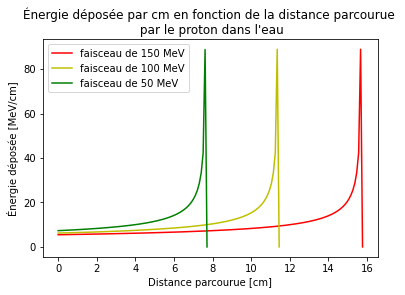

In [43]:
#Portées pour différentes valeurs d'énergies initiales 
x_eau_150, transport_eau_150 = proton_transport(150, 0.1, eau_liq["n_e"], eau_liq["MEE"], 1000)   
x_eau_125, transport_eau_125 = proton_transport(125, 0.1, eau_liq["n_e"], eau_liq["MEE"], 1000)   
x_eau_100, transport_eau_100 = proton_transport(100, 0.1, eau_liq["n_e"], eau_liq["MEE"], 1000) 

plt.plot(x_eau_150, transport_eau_150,"r-", label = "faisceau de 150 MeV")
plt.plot(x_eau_125, transport_eau_125,"y-", label = "faisceau de 100 MeV")
plt.plot(x_eau_100, transport_eau_100,"g-", label = "faisceau de 50 MeV")
plt.title("Énergie déposée par cm en fonction de la distance parcourue \n par le proton dans l'eau")
plt.xlabel("Distance parcourue [cm]")
plt.ylabel("Énergie déposée [MeV/cm]")
plt.legend()
plt.show() 

# Numéro 12 
Le pic de Bragg est très important en radiothérapie, car le but de cette procédure est de : "détruire
des cellules pathologiques (cancer par exemple) tout en épargnant les tissus sains environnants." En connaissant le pic de Bragg de la courbe de Bragg, il est possible de connaître à quelle profondeur le proton (ou n'importe quel autre rayonnement ionisant) dépose le plus d'énergie, ce qui permet de déposer un maximum d'énergie à la profondeur à laquelle les cellules pathologiques sont situées. Dans notre cas, cette profondeur peut être déterminée avec l'énergie initiale du proton incident, c'est d'ailleurs cette profondeur qui va tenter d'être trouvée au prochain numéro. 

# Numéro 13

In [47]:
def energy_melanoma(D,dT):
    # -- Calcul l'énergie d'un faisceau de protons pour traîter un mélanome oculaire situé à une distance D
    # -- Paramètres:
    #   D : distance du faisceau par rapport à la surface oculaire [cm]
    #   dT : Précision souhaitée [MeV], soit les ajouts incrémentals d'une énergie Ti initiale
    
    # Énergie cinétique initiale minimale [MeV] pour un Scol qui néglige les termes correctifs
    Ti = 3
     # distance plafond [cm] lors des comparaisons entre la position des pics de Bragg avec la distance voulue D
    d_plaf = 100
    # Boucle itérative de Tf sous forme de "array" à partir de 0
    # À chaque valeur de Tf, un pic de bragg est calculé
    for i in range(10000):
        Tf_array = np.linspace(0.02*Ti, 0, int(0.02 * Ti/dT))
        Tf_tuple = np.zeros(Tf_array.shape)
        for j, Tf in enumerate(Tf_array):
            Tf_tuple[j] = simpson(lambda T : 1 / Scol(eau_liq["n_e"], T, eau_liq["MEE"]), Tf, Ti, 100)
    
        Scol_array = Scol(eau_liq["n_e"], Tf_array, eau_liq["MEE"])
        pos_bragg = Tf_tuple[np.argmax(Scol_array)]
        
        #La position du pic de Bragg est ensuite comparé à la distance D
        distance_result = np.abs(pos_bragg - D)
        if distance_result <= d_plaf:   
            Ti_result = Ti
            d_plaf = distance_result
            Ti += dT
        else:
            break
    return Ti_result

# Le mélanome est à 4 cm de la surface oculaire
# On veut une précision de 0.01 MeV

Ti_final = energy_melanoma(4,0.01)

print("Il faut un faisceau de protons ayant une énergie de {:.2f} MeV pour traiter un mélanome situé à 4 cm de la surface oculaire.".format(Ti_final))

Il faut un faisceau de protons ayant une énergie de 69.29 MeV pour traiter un mélanome situé à 4 cm de la surface oculaire.


# Le Calcul itératif prend un peu plus d'une minute.

Il est à noter que les différentes parties d'un corps oculaire ont une densité approximative à celle de l'eau. Ainsi, il est possible d'utiliser la fonction Scol avec les informations du dictionnaire eau_liq. Voir l'article [Adult Human Ocular Volume: Scaling to Body Size and Composition](https://www.longdom.org/open-access/adult-human-ocular-volume-scaling-to-body-size-and-composition-2161-0940-1000239.pdf).

In [52]:
## Vérification ##

verif_melanoma = simpson(lambda T : 1/Scol(eau_liq["n_e"], T, eau_liq["MEE"]), Ti_final, 0, 500)
print("En calculant le pas de déplacement d'un proton ayant une énergie cinétique de {:.2f} MeV avant d'entrée dans une surface oculaire et 0 MeV après avoir subi l'atténuation du corps oculaire, on obtient {:.3f} cm.".format(Ti_final, verif_melanoma))
er_melanoma = np.abs(100*((verif_melanoma-4)/4))
print("Ce qui correspond à une erreur relative de {:.2f}% avec la valeur de 4 cm prévue.".format(er_melanoma))

En calculant le pas de déplacement d'un proton ayant une énergie cinétique de 69.29 MeV avant d'entrée dans une surface oculaire et 0 MeV après avoir subi l'atténuation du corps oculaire, on obtient 4.001 cm.
Ce qui correspond à une erreur relative de 0.01% avec la valeur de 4 cm prévue.


# Numéro 14

Les protons sont préférables aux photons pour traiter un mélanome oculaire, en raison de leur pic de Bragg qui est beaucoup plus étroit que le pic des photons. Ce qui permet aux protons d'aller plus en profondeur dans un matériau que les photons. Le fait que leur pic soit étroit aide les oncologistes, par exemple, a bien cibler le mélanome et à ne pas endommager le reste du corps oculaire. La figure suivante présente une comparaison entre le pic de Bragg des photons et des protons.
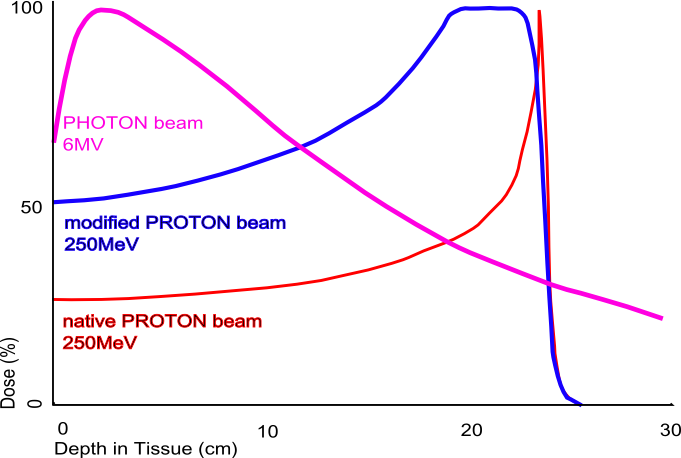


# Numéro 15

Oui, cette approximation est plutôt réaliste, mais pas exacte. Effectivement lorsqu'un proton ou une particule lourde se déplace dans la matière, leurs trajectoires sont relativement linéaires, mais celles-ci peuvent être déviées. Pour être plus précis, il faudrait rajouter les interactions coulombiennes avec les noyaux. Ces interactions élastiques causent la déflexion de la trajectoire du proton. Un autre bon ajout pourrait être d’utiliser la formule de Bethe avec les différentes corrections.